In [ ]:
import glob
from matplotlib import image 
from matplotlib import pyplot as plt
from PIL import Image
import os
import cv2 as cv
import numpy as np
import scipy.io
import random
from sklearn.cluster import KMeans

1.Downloading the data and Undersatnding it

In [ ]:
!wget -q {"http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"}
!tar -xzf /content/BSR_bsds500.tgz


In [ ]:
# Creating the output directory
!mkdir '/content/output'
!mkdir '/content/output/Ground-Truth'


mkdir: cannot create directory ‘/content/output’: File exists
mkdir: cannot create directory ‘/content/output/Ground-Truth’: File exists


In [ ]:
#saving output
directory = "content"
    
# Parent Directory path
parent_dir = "."

# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

## Create 'output' directory to save all outputs inside
directory = "output"
    
# Parent Directory path
parent_dir = "./content"
    
# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

## Create 'Ground Truth' directory
directory = "Ground-Truth"
    
# Parent Directory path
parent_dir = "./content/output"
    
# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

In [ ]:
#Get the images for training
training_images = sorted(glob.glob("BSR/BSDS500/data/images/train/**/*.jpg", recursive=True))

#Get the images for testing
testing_images = sorted(glob.glob("BSR/BSDS500/data/images/test/**/*.jpg", recursive=True))
testing_images = testing_images[0:50]

#Get the ground-truth for training
ground_truth_training = sorted(glob.glob("BSR/BSDS500/data/groundTruth/train/**/*.mat", recursive=True))

#Get the ground-truth for testing
ground_truth_testing = sorted(glob.glob("BSR/BSDS500/data/groundTruth/test/**/*.mat", recursive=True))
ground_truth_testing = ground_truth_testing[0:50]

2.Visualize the image and the ground truth segmentation


In [ ]:
def ground_truth_images_func(index,dataset):
  ground_truth_image = scipy.io.loadmat(dataset[index])
  ground_truth_image = np.squeeze(ground_truth_image['groundTruth'])
  ground_truth_images = [] #making a list for the ground truth images 
  for i in range(5):
    current_ground_truth = ground_truth_image[i][0][0][0]
    ground_truth_images.append(current_ground_truth)
  
  return ground_truth_images


In [ ]:
def read_image(index,dataset):
  path='./content/output/Ground-Truth'  #output is saved here
  file_name = str(dataset).lower() + ' ' + str(index) + ' visualization' #file name
  fig, axarr = plt.subplots(2,3, figsize = (15,15))

  if dataset == "TRAIN":
    normal_dataset = training_images
    ground_truth_dataset = ground_truth_training
  if dataset == "TEST":
    normal_dataset = testing_images
    ground_truth_dataset = ground_truth_testing

  #creating an empty list of images
  images = []  
  normal_image = image.imread(normal_dataset[index])
  images.append(normal_image)
  ground_truth_images = ground_truth_images_func(index,  ground_truth_dataset) # Getting the ground truth of the image
  images = images +ground_truth_images  # to display all
  #looping through the images list to show the image
  for i in range(len(images)):
    row = i // 3
    col = i % 3
    if i == 0:
      axarr[row][col].imshow(images[0])
    axarr[i // 3][i % 3].imshow(images[i], interpolation='nearest')
  fig.suptitle(file_name, fontsize=16)
  plt.savefig(os.path.join(path, file_name), bbox_inches = 'tight')
  plt.show()


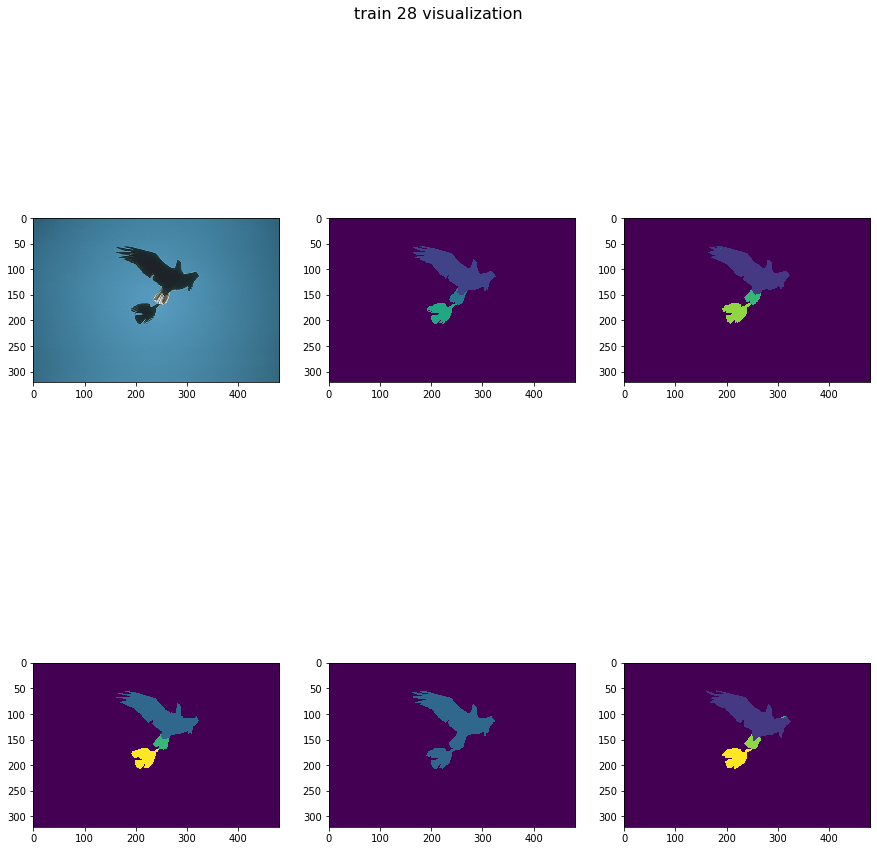

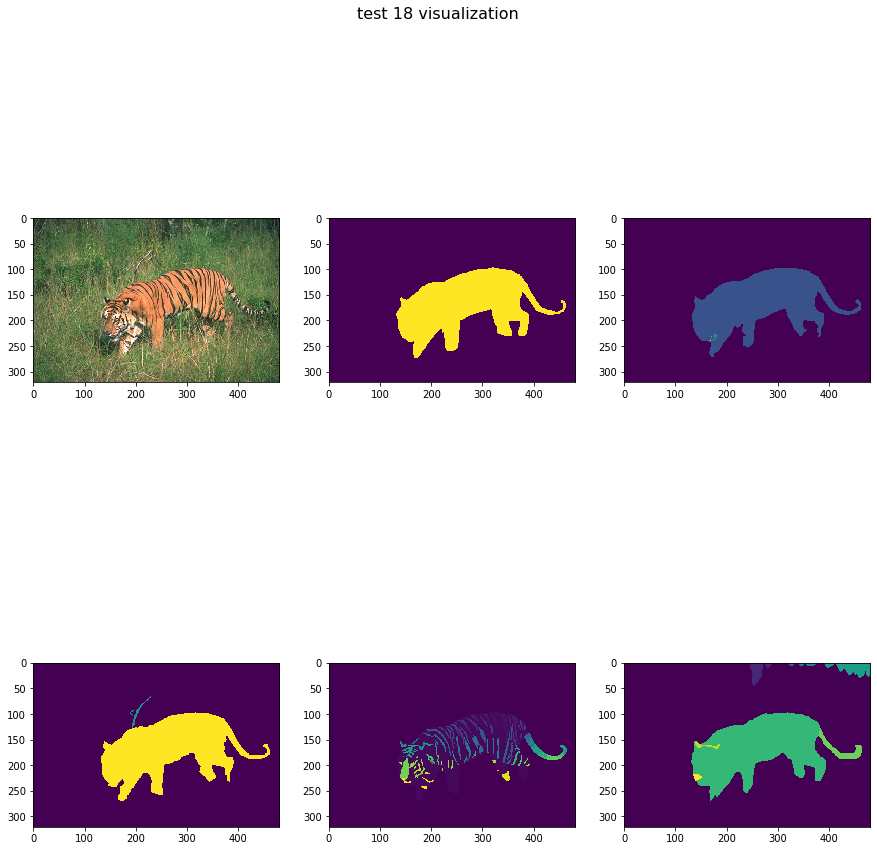

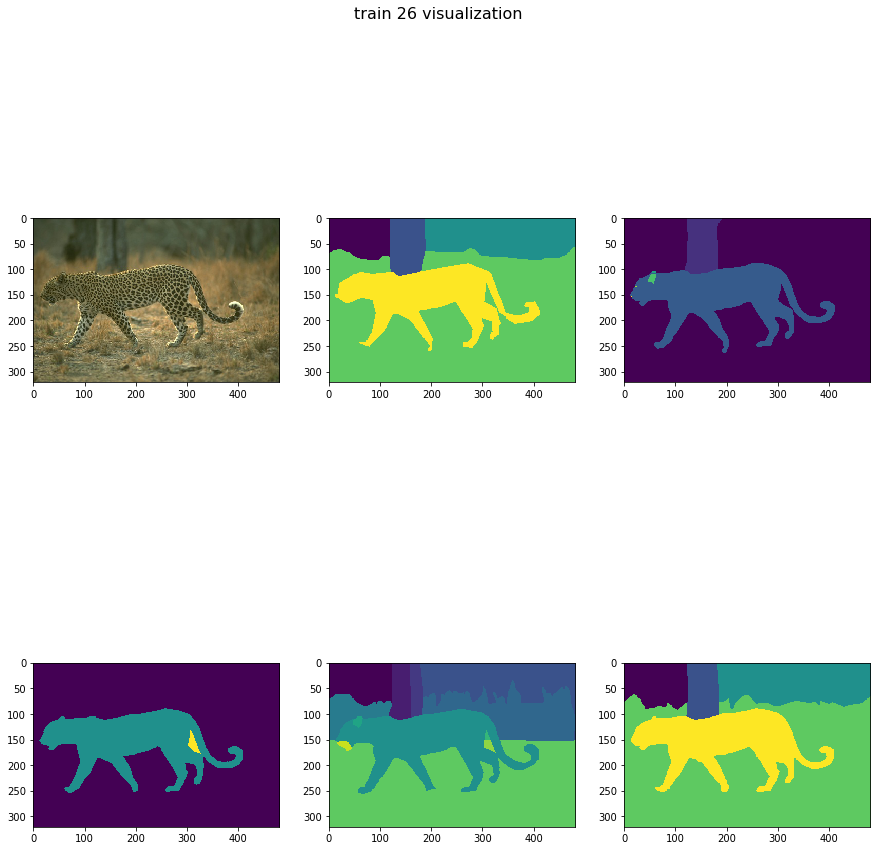

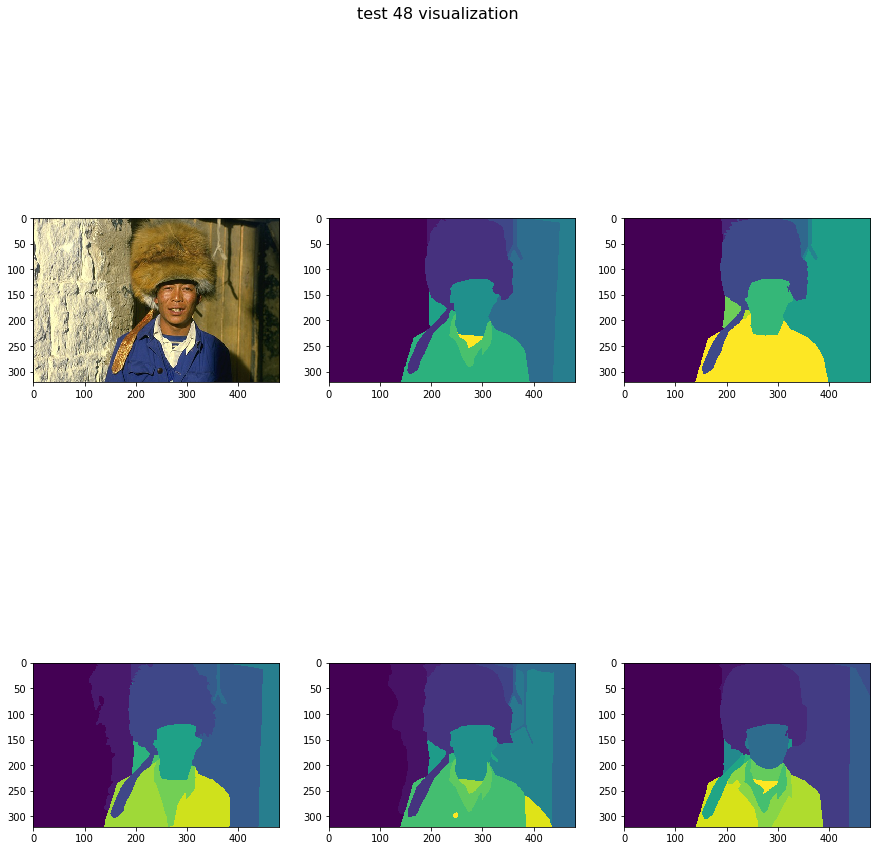

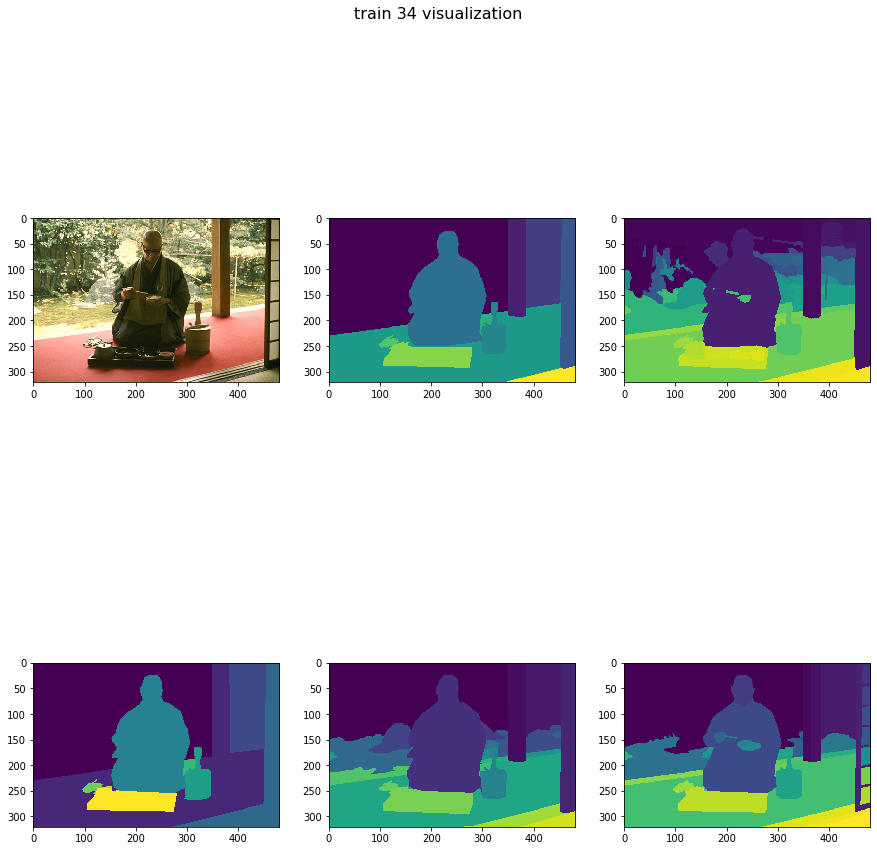

In [ ]:

datasets = ["TRAIN", "TEST"]
random_images = random.sample(range(0, 50), 5) # Calling the above function to get 2 random images to visualize

# Visualize a sample from training dataset and a sample from test data set alternatively
for i in range(len(random_images)):
    read_image(random_images[i], datasets[i & 1])

In [ ]:
'''# For the comparison part
f = []
for i in range(len(random_images)):
  f.append(ground_truth_images_func(random_images[i], datasets[i & 1]))'''

'# For the comparison part\nf = []\nfor i in range(len(random_images)):\n  f.append(ground_truth_images_func(random_images[i], datasets[i & 1]))'

In [ ]:
from google.colab import files
!zip -qq -r /content/output.zip /content/output
files.download("/content/output.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

K-means implementation

In [ ]:
K_range= [3,5,7,9,11]
